# SYBA fragment score preparation
SYBA needs two sets of compounds: easy-to-synthesize (ES) and hard-to-synthesize (HS). HS compounds were generated by Nonpher methodology (https://dx.doi.org/10.1186%2Fs13321-017-0206-2, source code is avilable at  https://github.com/lich-uct/nonpher.). The same amount of ES compounds were randomly chosen from the ZINC15 database.

However, Bayesian approach SYBA is based on is a general method that can be applied to any binary classification problem. Thus the steps described in this notebook can be easily modified and SYBA can be trained for the classification of compounds by other physico-chemical or biological properties that can be related to any set of descriptors the distribution of which can be obtained from the databases of positive and negative examples.

SYBA, Jupyter and RDKit are required and have to be installed previously

In [1]:
import math
import gzip
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules+
from rdkit.Chem import Draw
from IPython.display import SVG
from syba import syba

RDKit WARNING: [13:57:13] Enabling RDKit 2019.09.3 jupyter extensions


## Process compound files and calculate fragment counts
Fragment counts of ES and HS compounds are merged into a single dictionary and saved into one file.

The core of the calculation is demonstrated below. SYBA fragment score contributions are calculated by the syba.calculateScore() function. For the demonstration purposes, 20 fragments with the highest diference of their counts in ES and HS sets (both ways, HS-ES and ES-HS) are depicted with their SYBA fragment score.

## Get all fragment types from compound ES and HS sets

In [2]:
def processFile(path, smi_col=1):
    """
    For given compressed file, function returns number of all compounds and all Morgan fragment types with corresponding number of compounds
    in which they are found.
    
    path to data set (gzip csv file)
    smi_col is column where are SMILES, first column has index 0!
    
    return: dictionary with fragments and their counts and the number of processed compounds as tuple
    """
    with gzip.open(path, mode="rt") as reader:
        suppl = syba.SmiMolSupplier(reader, header=True, smi_col=smi_col) # reads reader line by line and returns tuple with RDMol and splitted line
        fs = {}
        n_of_compounds = 0
        for m, *spls in suppl:
            try:
                for frag in Chem.GetMorganFingerprint(m,2).GetNonzeroElements().keys():
                    d = fs.setdefault(frag, [0])
                    d[0] += 1
                n_of_compounds += 1
            except Exception as e:
                print(spls)
                raise e
        return fs, n_of_compounds

In [3]:
# resource files are compressed csv files in format ID,ZINC_SMILES,NONPHER_SMILES
# HS compounds
hs_fragments, hs_compounds = processFile("../data/structures_1.csv.gz", smi_col=2)
# ES compounds
es_fragments, es_compounds = processFile("../data/structures_2.csv.gz", smi_col=1)

In [4]:
# example of fragments and their counts
list(es_fragments.items())[:10]

[(30958271, [151]),
 (98513984, [389669]),
 (203749390, [31988]),
 (422715066, [195054]),
 (545884714, [6013]),
 (847433064, [36362]),
 (864662311, [72059]),
 (951226070, [595384]),
 (1202540357, [537]),
 (1352098234, [254])]

To calculate score, SYBA needs the number of ES and HS compounds and the number of each fragment in both sets, so let's put all these values into one dictionary and then to a file

In [5]:
def mergeFragmentCounts(es_fragments, hs_fragments):
    fragments = set(es_fragments.keys())
    fragments.update(hs_fragments.keys())
    fragment_counts = {}

    for f in fragments:
        fragment_counts[f] = (es_fragments.get(f, [0])[0], hs_fragments.get(f, [0])[0])
    return fragment_counts

In [6]:
fragment_counts = mergeFragmentCounts(es_fragments, hs_fragments)
# can be write into file with function from package and than loaded by SYBA
# arguments are: path to file, dictionary with fragment counts and collection with number of coumpounds in both sets
syba.writeCountFile("../out/syba.csv", fragment_counts, (es_compounds, hs_compounds))
# or is possible to write only scores, then SYBA classifier need the log-ratio between ES and HS compounds, default is 0, both sets have equal size
syba.writeScoreFile("../out/syba_score.csv", fragment_counts, (es_compounds, hs_compounds))

In [7]:
list(fragment_counts.items())[:10]

[(2852126722, (0, 1)),
 (3397386243, (0, 1)),
 (3573547011, (0, 1)),
 (2231369733, (0, 1)),
 (1484783622, (16, 3)),
 (1233125380, (0, 1)),
 (1132462088, (0, 1)),
 (369098763, (0, 1)),
 (1233125389, (0, 1)),
 (2600468497, (0, 1))]

## The biggest difference between fragment counts in ES and HS sets

In [8]:
sorted_frgs = sorted(fragment_counts.items(), key=lambda k: k[1][0]-k[1][1])
most_HS_fragments = sorted_frgs[:9]
most_ES_fragments = sorted_frgs[-9:]

In [9]:
# score can be calculated with package function
# arguments are number of feasible compounds with fragment, infeasible compounds with fragment, number of feasible compounds and number of infeasible compounds
fragment_scores = {frg: syba.calculateScore(counts[0], counts[1], es_compounds, hs_compounds)[0] for frg, counts in fragment_counts.items()}

In [10]:
def getFragmentEnv(m, frgs=set()):
    """
    Function returns environment (indices of atoms in compound) of provided fragment types
    """
    info={}
    fp = Chem.GetMorganFingerprint(m,2,bitInfo=info)
    env = [(i, info[i]) for i in info if i in frgs]
    return env

In [11]:
hs_ts = [] # list of tuples with RDMol and with fragment tuple (its ids and root atoms with size of neighbourhoods)
es_ts = []

hs_frgs = {frg for frg, score in most_HS_fragments}
with gzip.open("../data/structures_1.csv.gz", mode="rt") as reader:
    for mol, *spls in syba.SmiMolSupplier(reader, header=True, smi_col=2):
        r = getFragmentEnv(mol, hs_frgs)
        if r:
            hs_ts.append((mol, r))
            hs_frgs.remove(r[0][0])
            if not hs_frgs:
                break
del hs_frgs # should be empty

es_frgs = {frg for frg, score in most_ES_fragments}
with gzip.open("../data/structures_2.csv.gz", mode="rt") as reader:
    for mol, *spls in syba.SmiMolSupplier(reader, header=True, smi_col=1):
        r = getFragmentEnv(mol, es_frgs)
        if r:
            es_ts.append((mol, r))
            es_frgs.remove(r[0][0])
            if not es_frgs:
                break
                
del es_frgs # should be empty

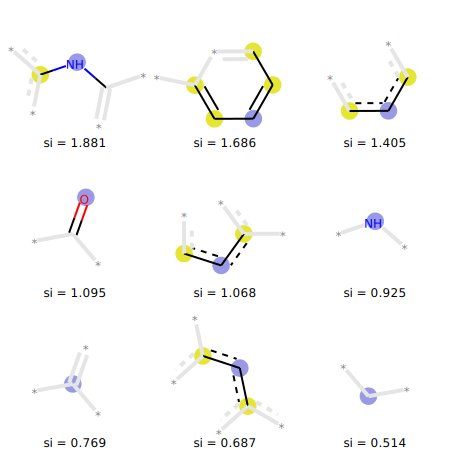

In [12]:
es_environments = []
es_legends = []
es_scores = []
es_frgs = set()
for mol, ob in es_ts:
    for frg, envs in ob:
        if frg not in es_frgs:
            es_environments.append((mol, envs[0][0], envs[0][1]))
            score = fragment_scores[frg]
            es_scores.append(score)
            es_legends.append(f"si = {score:.03f}")
            es_frgs.add(frg)
es_environments, es_legends, es_scores = zip(*sorted(zip(es_environments, es_legends, es_scores), key = lambda x: x[2], reverse= True))
# to run this code RDKit Q3 2019 is needed
SVG(Draw.DrawMorganEnvs(es_environments, legends=es_legends, ))

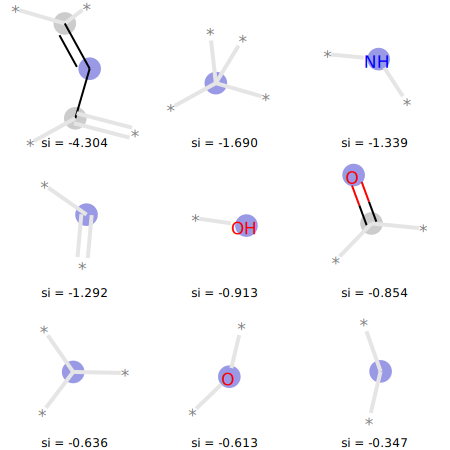

In [13]:
hs_environments = []
hs_legends = []
hs_scores = []
hs_frgs = set()
for mol, ob in hs_ts:
    for frg, envs in ob:
        if frg not in hs_frgs:
            hs_environments.append((mol, envs[0][0], envs[0][1]))
            score = fragment_scores[frg]
            hs_scores.append(score)
            hs_legends.append(f"si = {score:.03f}")
            hs_frgs.add(frg)
hs_environments, hs_legends, hs_scores = zip(*sorted(zip(hs_environments, hs_legends, hs_scores), key = lambda x: x[2]))
SVG(Draw.DrawMorganEnvs(hs_environments, legends=hs_legends, ))